In [2]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd

import urllib
import requests
import json

# Users

In [3]:
def get_locale(x):
    if x.find('_') != -1:
        return x.split('_')[1]
    else:
        return np.nan

def get_birth_year(x):
    if x.isdigit():
        return x
    else:
        return np.nan
    
def get_joined_at(x):
    if type(x) is str and x.find('T') != -1:
        return x.split('T')[0]
    else:
        return np.nan
    
users = pd.read_csv('data/users.csv')
users.set_index('user_id', inplace=True)

users.locale = users.locale.apply(get_locale)
users.birthyear = users.birthyear.apply(get_birth_year)
users.joinedAt = users.joinedAt.apply(get_joined_at)

users.head()

,locale,birthyear,gender,joinedAt,location,timezone
user_id,,,,,,
3197468391,ID,1993,male,2012-10-02,Medan Indonesia,480.0
3537982273,ID,1992,male,2012-09-29,Medan Indonesia,420.0
823183725,US,1975,male,2012-10-06,Stratford Ontario,-240.0
1872223848,US,1991,female,2012-11-04,Tehran Iran,210.0
3429017717,ID,1995,female,2012-09-10,NaN,420.0


In [3]:
googleGeocodeUrl = 'https://maps.googleapis.com/maps/api/geocode/json?'

def geocode(address):
    params = {
        'address': address}

    url = googleGeocodeUrl + urllib.parse.urlencode(params)
    print(url)
    response = urllib.request.urlopen(url)
    response_list = list(response)
    line = json.loads(''.join([x.decode("utf-8") for x in response_list]))
    latitude = line['results'][0]['geometry']['location']['lat']
    longitude = line['results'][0]['geometry']['location']['lng']
    return latitude, longitude


locations = pd.DataFrame({'location': users.location, 'count': 1})
location_counts = locations.groupby('location').count()

lats, lngs = [], []
for location in location_counts.index:
    try:
        lat, lng = geocode(location)
        lats.append(lat)
        lngs.append(lng)
    except:
        print('Error location: %s' % location)
        lats.append(np.nan)
        lngs.append(np.nan)

https://maps.googleapis.com/maps/api/geocode/json?address=++
Error location:   
https://maps.googleapis.com/maps/api/geocode/json?address=Abadan++Iran
https://maps.googleapis.com/maps/api/geocode/json?address=Abadeh
https://maps.googleapis.com/maps/api/geocode/json?address=Abbottabad
https://maps.googleapis.com/maps/api/geocode/json?address=Aberdeen
https://maps.googleapis.com/maps/api/geocode/json?address=Aberdeen++SD
https://maps.googleapis.com/maps/api/geocode/json?address=Abhar
https://maps.googleapis.com/maps/api/geocode/json?address=Abia++Ebonyi++Nigeria
https://maps.googleapis.com/maps/api/geocode/json?address=Abidjan++82
https://maps.googleapis.com/maps/api/geocode/json?address=Abidjan++Cote+d%27Ivoire
https://maps.googleapis.com/maps/api/geocode/json?address=Ablagh++05
Error location: Ablagh  05
https://maps.googleapis.com/maps/api/geocode/json?address=Absecon++NJ
https://maps.googleapis.com/maps/api/geocode/json?address=Abu+Dhabi++01
https://maps.googleapis.com/maps/api/geoco

ValueError: Length of values does not match length of index

In [9]:
location_counts['lat'] = lats
location_counts['lng'] = lngs

In [15]:
users = users.join(location_counts, on=['location'])

In [19]:
users.head()

,locale,birthyear,gender,joinedAt,location,timezone,count,lat,lng
user_id,,,,,,,,,
3197468391,ID,1993,male,2012-10-02,Medan Indonesia,480.0,4509.0,3.595196,98.672223
3537982273,ID,1992,male,2012-09-29,Medan Indonesia,420.0,4509.0,3.595196,98.672223
823183725,US,1975,male,2012-10-06,Stratford Ontario,-240.0,1.0,43.370001,-80.982229
1872223848,US,1991,female,2012-11-04,Tehran Iran,210.0,116.0,35.689197,51.388974
3429017717,ID,1995,female,2012-09-10,NaN,420.0,NaN,NaN,NaN


In [77]:
users.to_csv('data/superset/users.csv', index=False)

In [79]:
clickhouse_url = 'http://default@localhost:8123/?'
clickhouse_query_url = 'http://localhost:8123/?query="%s"'

def create_tables(db='mydb', recreate=True):
    if recreate:
        r = requests.post(clickhouse_url, 
                          data=open('data/superset/drop.sql', 'rb').read(),
                          headers={'Content-Type': 'application/octet-stream'})
        print(r.reason)
    r = requests.post(clickhouse_url, 
                      data=open('data/superset/create.sql', 'rb').read(),
                      headers={'Content-Type': 'application/octet-stream'})
    print(r.reason)


In [80]:
create_tables()

OK
OK


In [81]:
r = requests.post(clickhouse_url + 'query=INSERT INTO mydb.users FORMAT CSVWithNames',
                  data=open('data/superset/users.csv', 'rb'),
                  headers={'content-type': 'text/csv'})

r.reason

'OK'

# Users friends

In [11]:
user_friends = pd.read_csv('data/user_friends.csv')
user_friends.set_index('user', inplace=True)

user_friends.friends = user_friends.friends.apply(lambda x: [int(x) for x in x.split()] 
                                                             if x is not np.nan else [])
user_friends['counts'] = [len(x) for x in user_friends['friends']]

user_friends.head()

,friends,counts
user,,
3197468391,"[1346449342, 3873244116, 4226080662, 122290762...",3623
3537982273,"[1491560444, 395798035, 2036380346, 899375619,...",1467
823183725,"[1484954627, 1950387873, 1652977611, 418596082...",96
1872223848,"[83361640, 723814682, 557944478, 1724049724, 2...",13
3429017717,"[4253303705, 2130310957, 1838389374, 392873576...",1136


(array([  1.45890999e-03,   9.08852518e-04,   7.09996536e-04,
          5.49582880e-04,   4.28560743e-04,   3.50885097e-04,
          2.84916168e-04,   2.37140109e-04,   1.87623862e-04,
          1.40006001e-04,   1.15643375e-04,   9.44447264e-05,
          8.19470155e-05,   6.53361340e-05,   5.47368096e-05,
          4.46120818e-05,   3.74931326e-05,   3.27471664e-05,
          2.95831890e-05,   3.05323822e-05,   1.81928702e-05,
          1.80346714e-05,   1.77182736e-05,   1.39215007e-05,
          1.69272793e-05,   1.69272793e-05,   2.18314443e-05,
          3.70185360e-05,   3.44873540e-05,   4.90416502e-06]),
 array([    0.        ,   165.46666667,   330.93333333,   496.4       ,
          661.86666667,   827.33333333,   992.8       ,  1158.26666667,
         1323.73333333,  1489.2       ,  1654.66666667,  1820.13333333,
         1985.6       ,  2151.06666667,  2316.53333333,  2482.        ,
         2647.46666667,  2812.93333333,  2978.4       ,  3143.86666667,
         3309.3333

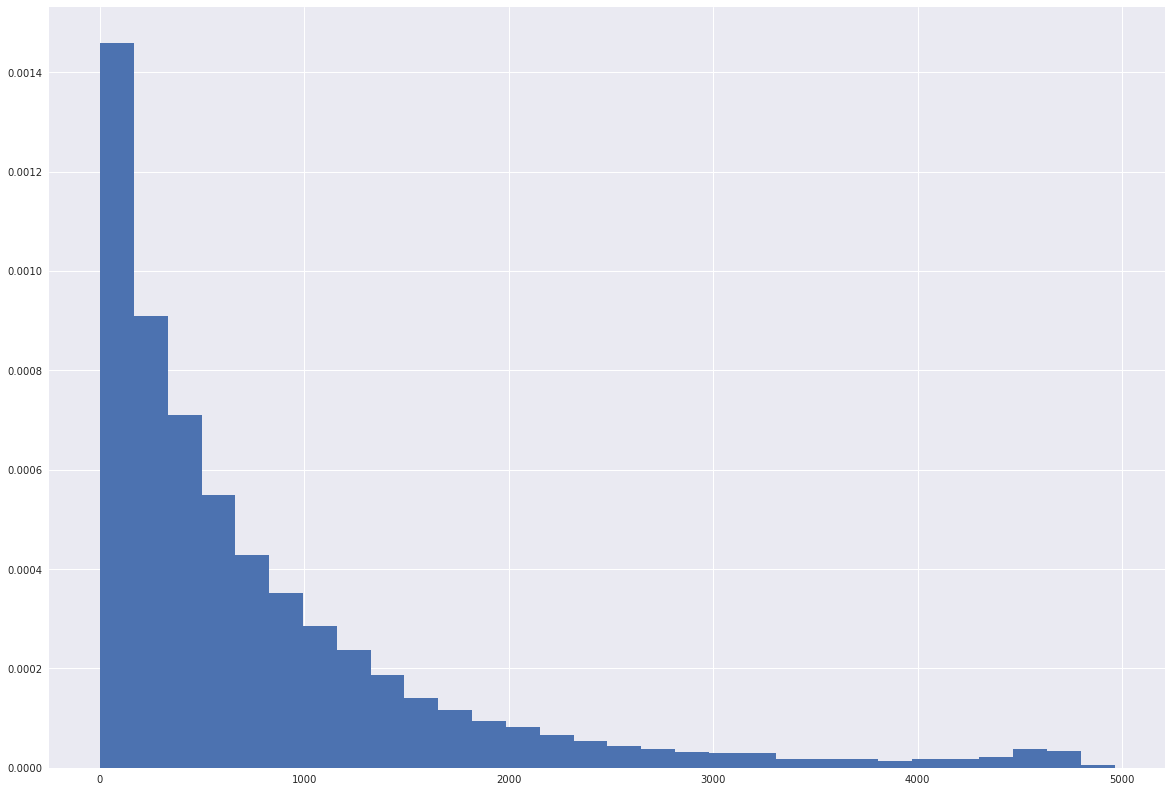

In [12]:
plt.hist(user_friends['counts'], 30, normed=True)

In [13]:
if 1 == 0:
    plt.figure(figsize=(20, 14))

    G = nx.Graph()

    G.add_nodes_from(list(users.index.values))

    i = 0
    for user_id, row in user_friends.iterrows():
        friend_ids = [int(s_id) for s_id in row['friends'].split()]
        G.add_edges_from([(user_id, friend_id) for friend_id in friend_ids], color='blue')
        i += 1
        if i == 100:
            break

    nx.draw(G)

    plt.savefig('data/graph.png')

# Events

In [14]:
def get_start_time(x):
    if type(x) is str and x.find('T') != -1:
        return x.split('T')[0]
    else:
        return np.nan

events = pd.read_csv('data/events.csv')
events.set_index('event_id', inplace=True)

events.start_time = events.start_time.apply(get_start_time)

events.head()

,user_id,start_time,city,state,zip,country,lat,lng,c_1,c_2,...,c_92,c_93,c_94,c_95,c_96,c_97,c_98,c_99,c_100,c_other
event_id,,,,,,,,,,,,,,,,,,,,,
684921758,3647864012,2012-10-31,NaN,NaN,NaN,NaN,NaN,NaN,2,0,...,0,1,0,0,0,0,0,0,0,9
244999119,3476440521,2012-11-03,NaN,NaN,NaN,NaN,NaN,NaN,2,0,...,0,0,0,0,0,0,0,0,0,7
3928440935,517514445,2012-11-05,NaN,NaN,NaN,NaN,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,0,12
2582345152,781585781,2012-10-30,NaN,NaN,NaN,NaN,NaN,NaN,1,0,...,0,0,0,0,0,0,0,0,0,8
1051165850,1016098580,2012-09-27,NaN,NaN,NaN,NaN,NaN,NaN,1,1,...,0,0,0,0,0,0,0,0,0,9


In [15]:
events.shape[0]

3137972

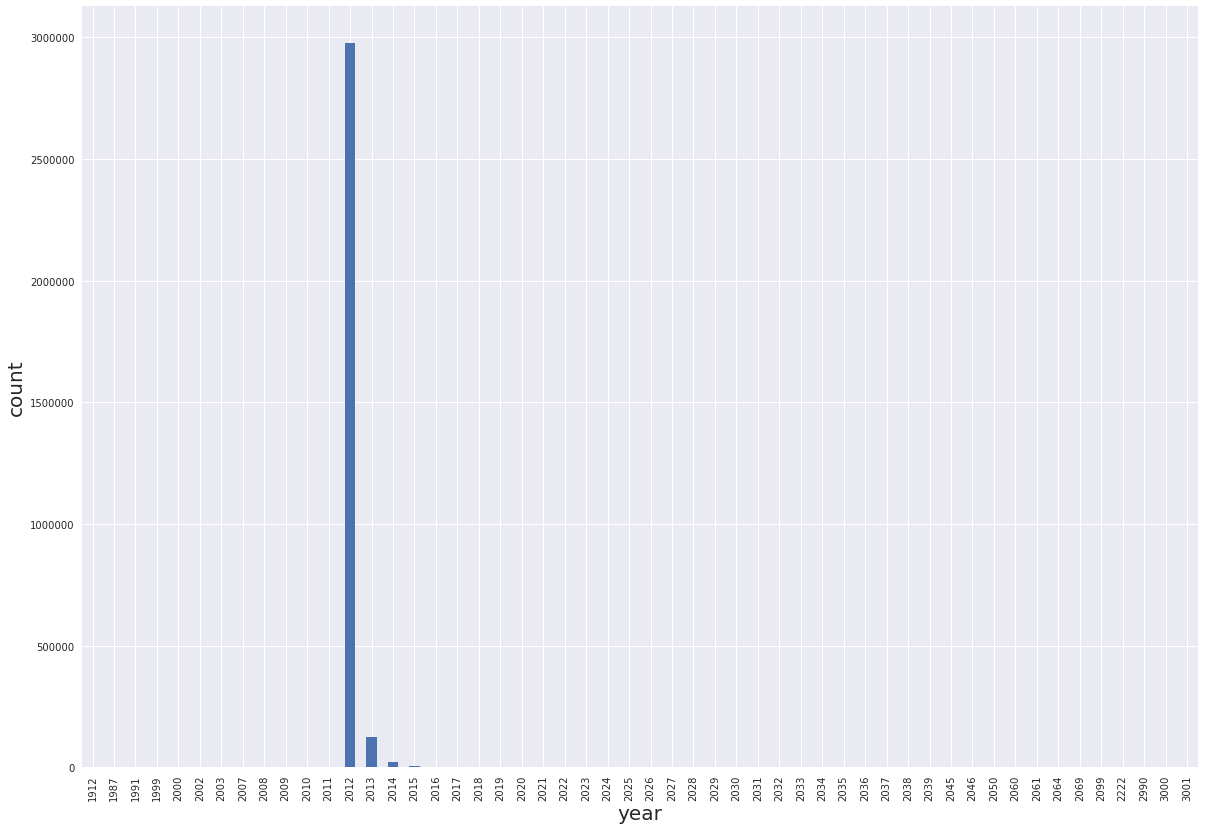

In [31]:
(events.start_time.apply(lambda x: x.split('-')[0] if x.find('-') != -1 else np.nan)
                  .value_counts()
                  .sort_index()
                  .plot(kind='bar'))
plt.xlabel('year')
plt.ylabel('count')

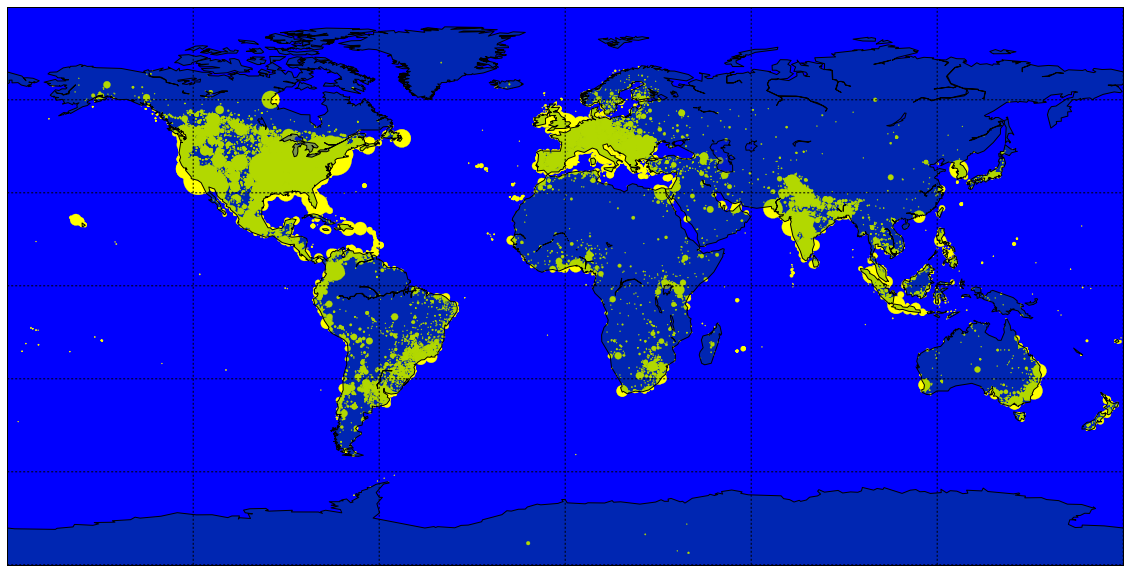

In [16]:
m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=-180,urcrnrlon=180,resolution='c')
m.drawcoastlines()
m.fillcontinents(color='green',lake_color='blue', alpha=0.3)
m.drawparallels(np.arange(-90.,91.,30.))
m.drawmeridians(np.arange(-180.,181.,60.))
m.drawmapboundary(fill_color='blue')

points = events[['lat', 'lng']]
points['count'] = 1

point_counts = points.groupby(['lat', 'lng']).count().reset_index()
plt.scatter(point_counts['lng'], 
            point_counts['lat'], 
            s=point_counts['count'],
            c='yellow')

# Event attendees

In [47]:
event_attendees = pd.read_csv('data/event_attendees.csv', index_col='event')

event_attendees.yes = event_attendees.yes.apply(lambda x: map(int, x.split()) 
                                                if x is not np.nan else np.nan)
event_attendees.maybe = event_attendees.maybe.apply(lambda x: map(int, x.split()) 
                                                    if x is not np.nan else np.nan)
event_attendees.no = event_attendees.no.apply(lambda x: map(int, x.split()) 
                                              if x is not np.nan else np.nan)
event_attendees.invited = event_attendees.invited.apply(lambda x: map(int, x.split()) 
                                                        if x is not np.nan else np.nan)

event_attendees.head()

,yes,maybe,invited,no
event,,,,
1159822043,"[1975964455, 252302513, 4226086795, 3805886383...","[2733420590, 517546982, 1350834692, 532087573,...","[1723091036, 3795873583, 4109144917, 356062290...","[3575574655, 1077296663]"
686467261,"[2394228942, 2686116898, 1056558062, 379294223...","[1498184352, 645689144, 3770076778, 331335845,...","[1788073374, 733302094, 1830571649, 676508092,...",NaN
1186208412,NaN,"[3320380166, 3810793697]","[1379121209, 440668682]","[1728988561, 2950720854]"
2621578336,NaN,NaN,NaN,NaN
855842686,"[2406118796, 3550897984, 294255260, 1125817077...","[2671721559, 1761448345, 2356975806, 266666946...","[1518670705, 880919237, 2326414227, 2673818347...",[3500235232]


In [74]:
event_counts = deepcopy(event_attendees)
event_counts.yes = event_counts.yes.apply(lambda x: len(x) if x is not np.nan else 0)
event_counts.maybe = event_counts.maybe.apply(lambda x: len(x) if x is not np.nan else 0)
event_counts.no = event_counts.no.apply(lambda x: len(x) if x is not np.nan else 0)
event_counts.invited = event_counts.invited.apply(lambda x: len(x) if x is not np.nan else 0)
event_counts['count'] = 1

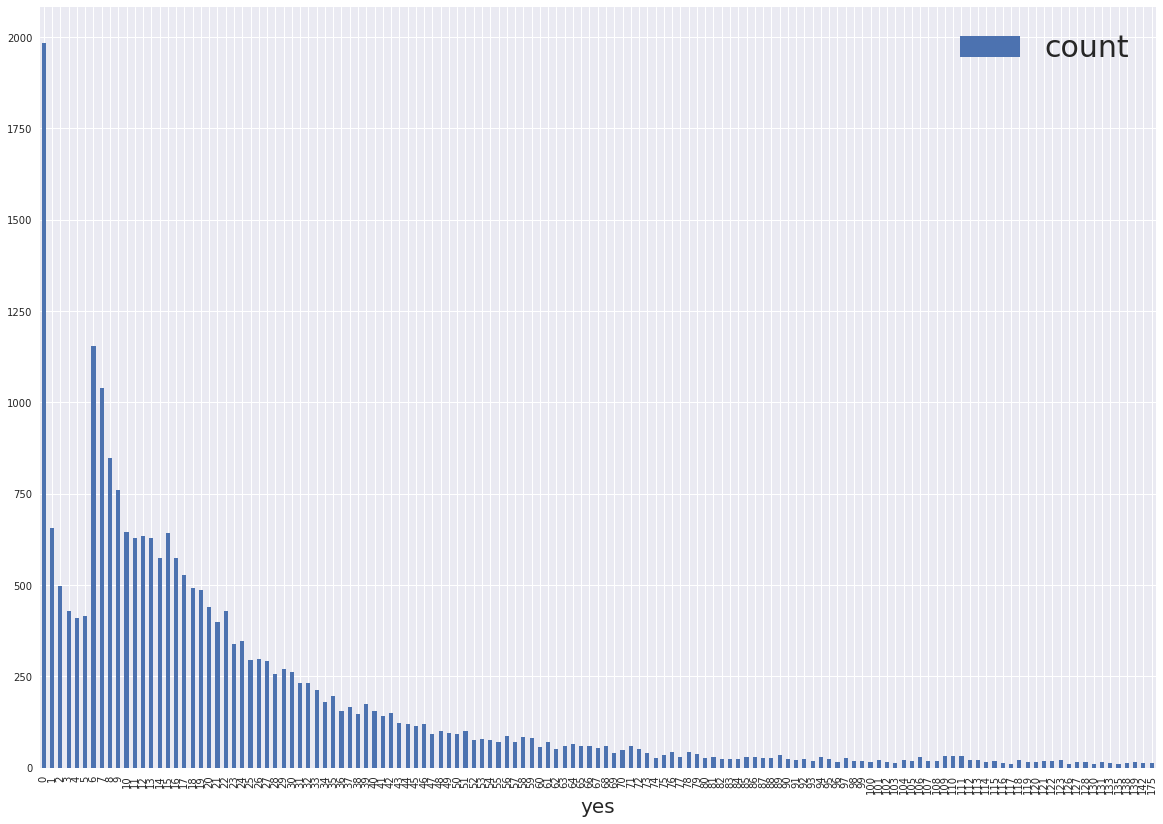

In [82]:
values = event_counts.groupby('yes').agg({'count': sum})
values = values[values['count'] > 10]
values.plot(kind='bar')

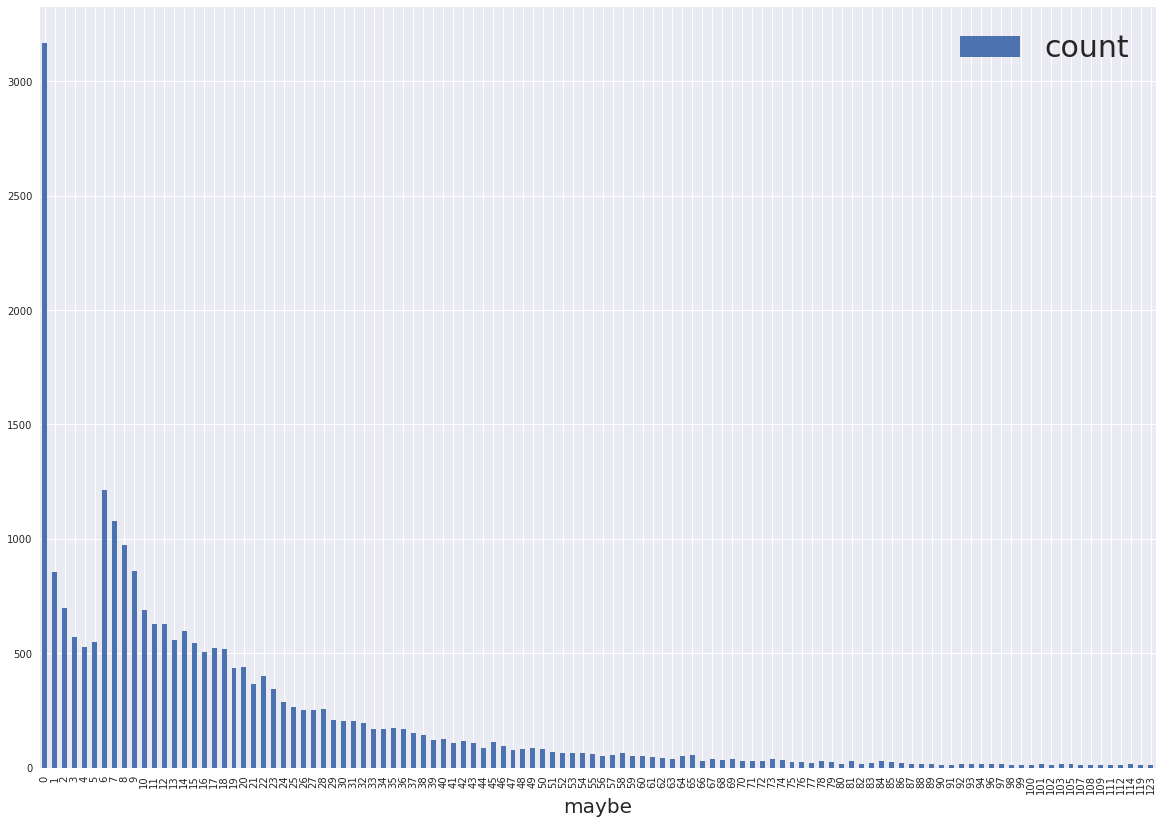

In [83]:
values = event_counts.groupby('maybe').agg({'count': sum})
values = values[values['count'] > 10]
values.plot(kind='bar')

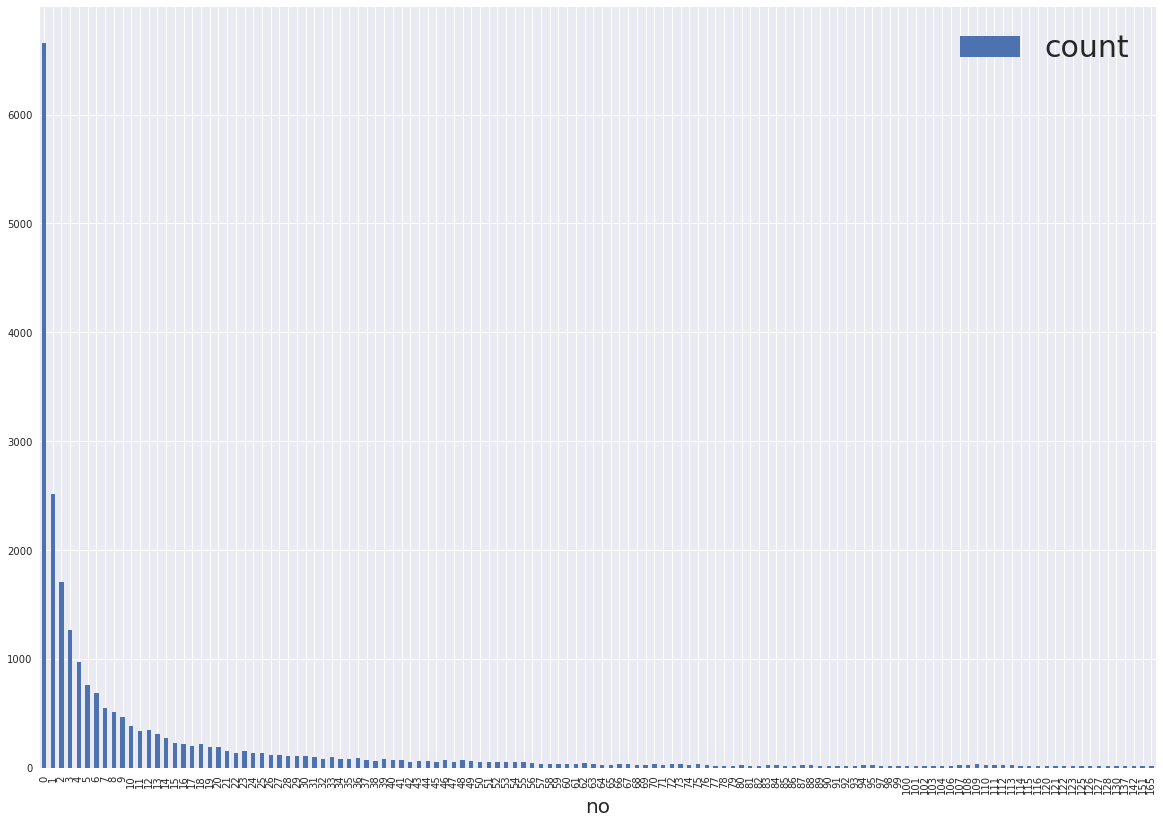

In [84]:
values = event_counts.groupby('no').agg({'count': sum})
values = values[values['count'] > 10]
values.plot(kind='bar')

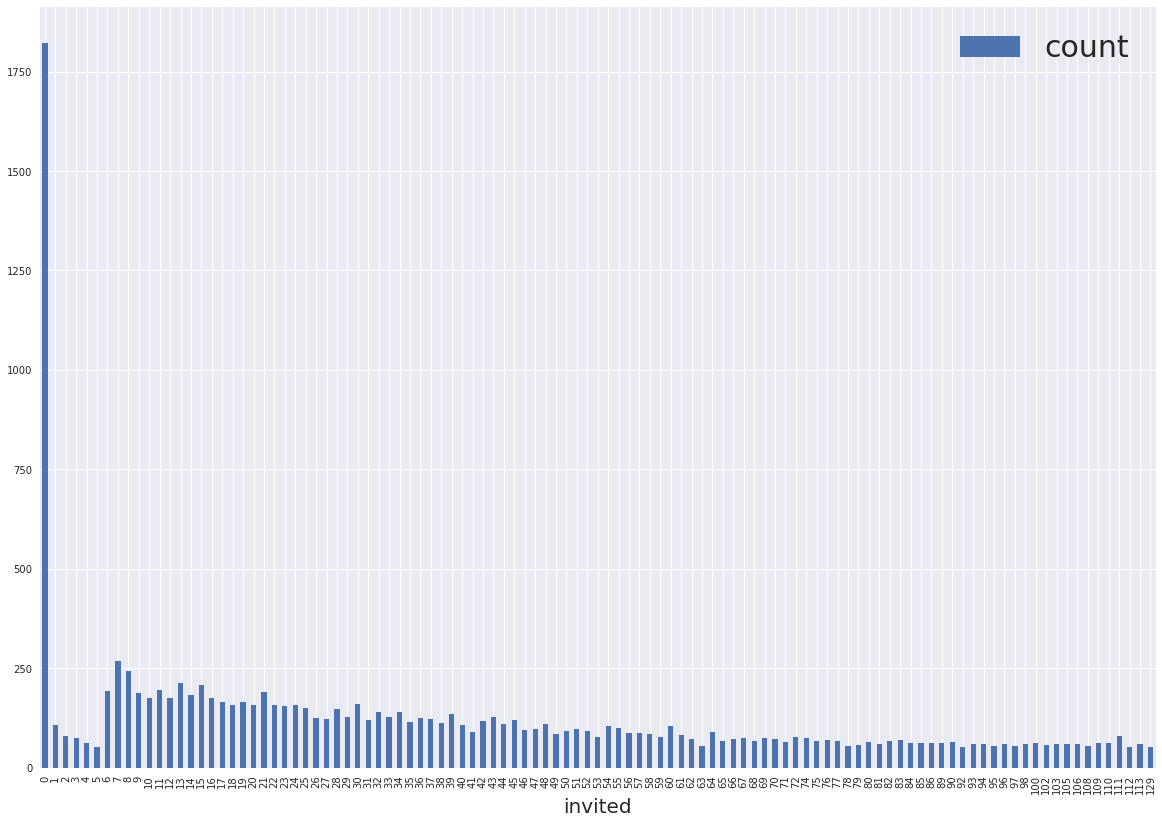

In [87]:
values = event_counts.groupby('invited').agg({'count': sum})
values = values[values['count'] > 50]
values.plot(kind='bar')

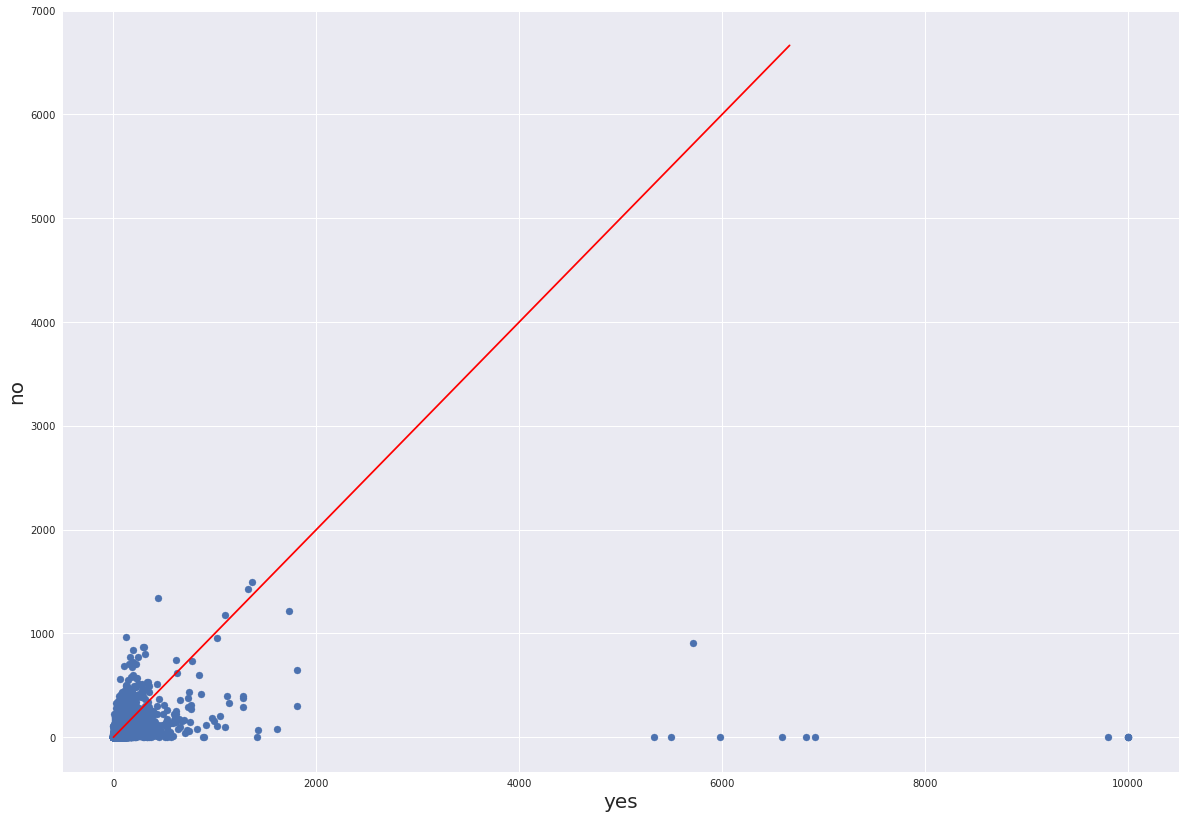

In [99]:
plt.scatter(event_counts['yes'], event_counts['no'])
plt.plot([i for i in range(6666)], c='red')
plt.xlabel('yes')
plt.ylabel('no')

In [114]:
values = event_counts[event_counts['yes'] > 4000]
values = values.join(events.loc[values.index])

values

,yes,maybe,invited,no,count,user_id,start_time,city,state,zip,...,c_92,c_93,c_94,c_95,c_96,c_97,c_98,c_99,c_100,c_other
event,,,,,,,,,,,,,,,,,,,,,
90124184,5709,902,2486,903,1,1.408848e+09,2012-12-20,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0
1270020700,6911,2378,709,0,1,2.735244e+09,2013-01-01,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0
2402634095,6824,2273,902,0,1,2.735244e+09,2013-01-02,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
2451246186,6588,2500,910,0,1,2.735244e+09,2013-01-05,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
2278755941,9999,0,0,0,1,4.093422e+09,2012-12-22,NaN,NaN,NaN,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0
2188393190,9999,0,0,0,1,1.359462e+09,2012-12-22,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
1951611940,5981,2482,1537,0,1,2.735244e+09,2013-01-06,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
150733034,10000,0,0,0,1,2.848080e+09,2013-01-01,NaN,NaN,NaN,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,74.0
2031830745,9803,197,0,0,1,3.805675e+09,2013-01-01,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0


In [127]:
values[values['user_id'] == values.loc[1270020700]['user_id']]

,yes,maybe,invited,no,count,user_id,start_time,city,state,zip,...,c_92,c_93,c_94,c_95,c_96,c_97,c_98,c_99,c_100,c_other
event,,,,,,,,,,,,,,,,,,,,,
1270020700,6911,2378,709,0,1,2.735244e+09,2013-01-01,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0
2402634095,6824,2273,902,0,1,2.735244e+09,2013-01-02,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
2451246186,6588,2500,910,0,1,2.735244e+09,2013-01-05,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
1951611940,5981,2482,1537,0,1,2.735244e+09,2013-01-06,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
3585709696,5324,2356,2320,0,1,2.735244e+09,2013-01-13,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0


# Train

In [19]:
train = pd.read_csv('data/train.csv')
train.head()

,user,event,invited,timestamp,interested,not_interested
0,3044012,1918771225,0,2012-10-02 15:53:05.754000+00:00,0,0
1,3044012,1502284248,0,2012-10-02 15:53:05.754000+00:00,0,0
2,3044012,2529072432,0,2012-10-02 15:53:05.754000+00:00,1,0
3,3044012,3072478280,0,2012-10-02 15:53:05.754000+00:00,0,0
4,3044012,1390707377,0,2012-10-02 15:53:05.754000+00:00,0,0


In [22]:
train.shape[0]

15398

### Как распределено число событий, которым пользователь поставил отметку?
### Есть ли особо активные пользователи?

In [23]:
event_count_per_user = (train[['user', 'event']]
                        .groupby('user')
                        .count())

print('Самые активные пользователи')
print(event_count_per_user.sort('event', ascending=False)[:10])
print('\n\nСамые неактивные пользователи:')
print(event_count_per_user.sort('event', ascending=True)[:10])

Самые активные пользователи
            event
user             
2903662804     91
3514195773     55
1067164735     49
3943175229     49
3180412264     48
3835637004     46
4075466480     45
3406326706     41
2895220130     37
3834655845     35


Самые неактивные пользователи:
            event
user             
3554343061      4
645414373       4
61814256        4
2086869786      4
630652349       4
236194065       4
2501052021      4
4181452333      4
4180930546      4
1127657981      4


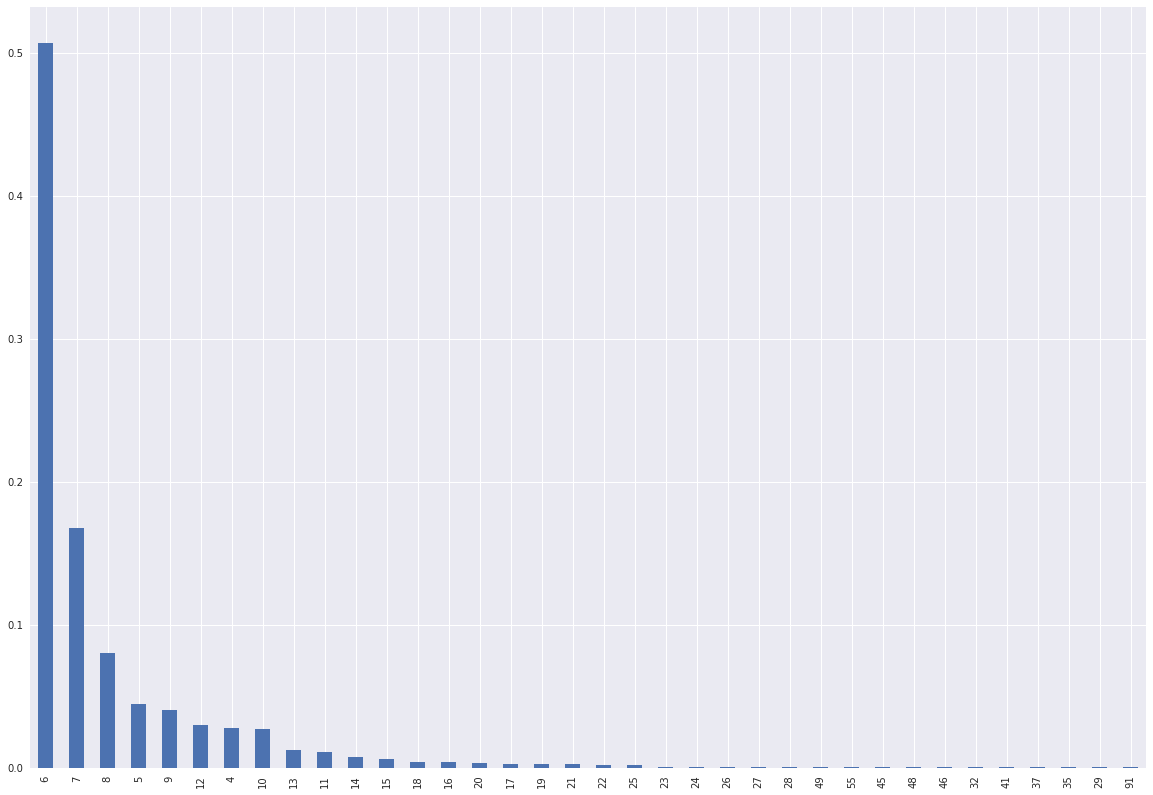

In [24]:
event_dist = event_count_per_user['event'].value_counts(normalize=True)
event_dist.plot(kind='bar')

### Как распределено число пользователей, поставивших отметку событию?
### Есть ли особо популярные события?

In [25]:
user_count_per_event = (train[['user', 'event']]
                        .groupby('event')
                        .count())

print('Популярные события:')
print(user_count_per_event.sort('user', ascending=False)[:10])
print('\n\nНепопулярные события:')
print(user_count_per_event.sort('user', ascending=True)[:10])

Популярные события:
            user
event           
955398943    242
2007279414   196
2529072432   187
1269035551   147
1600413013   114
1390707377    99
1076364848    98
1532377761    96
2149464820    89
268233790     80


Непопулярные события:
            user
event           
104070         1
2708587571     1
2708243586     1
2707138548     1
2706889282     1
2705882453     1
2705765590     1
2705316616     1
2704376528     1
2704261655     1


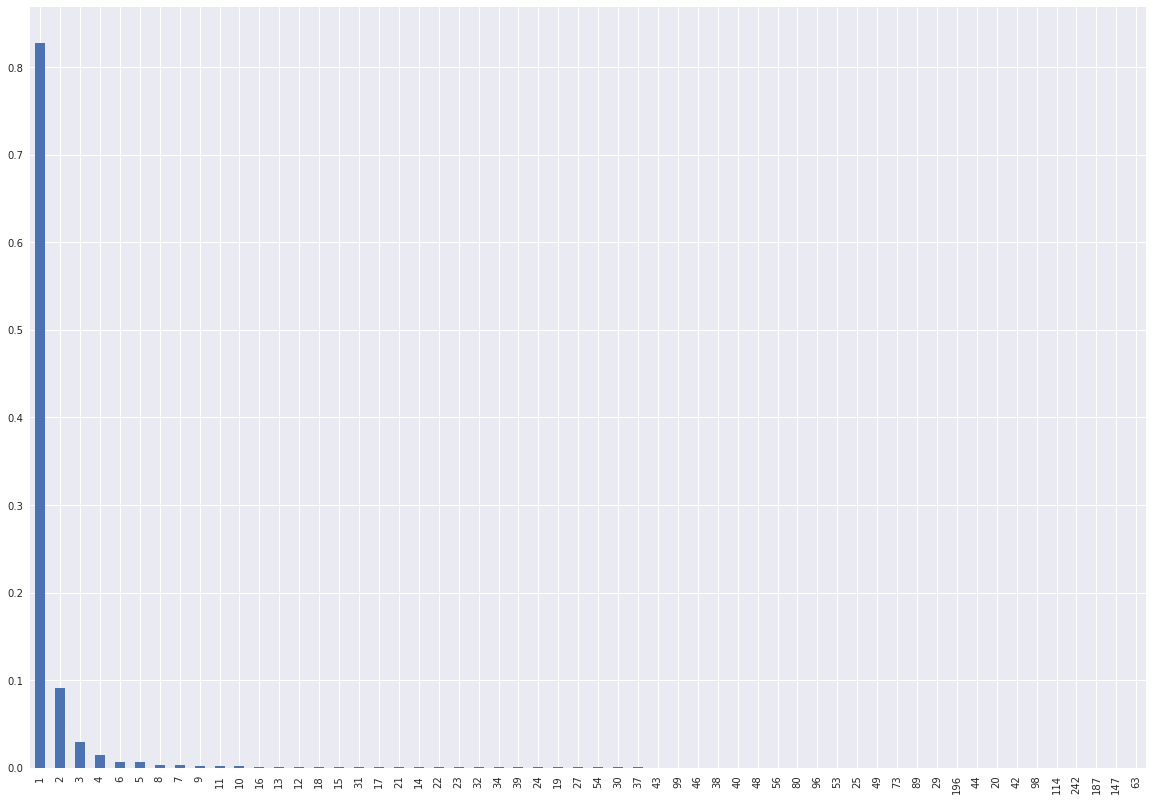

In [26]:
user_dist = user_count_per_event['user'].value_counts(normalize=True)
user_dist.plot(kind='bar')

### Сколько в выборке событий с отметкой interested? с отметкой not interested? без отметок?

In [27]:
counts = pd.DataFrame({'y': train['interested'] - train['not_interested'], 'count': 1}, train.index)
counts.groupby('y').count()

,count
y,
-1,514
0,10753
1,4131


# Preprocessing

In [140]:
y = counts['y']

x_train, x_valid, y_train, y_valid = train_test_split(train[['user', 'event', 'invited', 'timestamp']], 
                                                      y, 
                                                      test_size=0.3)
print(x_train.shape[0], x_valid.shape[0])

(10778, 4620)


# Memory-Based Collaborative Filtering

In [143]:
r = pd.pivot_table(x_train, values='interested', index=['user'], columns=['event'], aggfunc=sum, dropna=False)

# Latent Models for Collaborative Filtering

# Test

In [101]:
test = pd.read_csv('data/test.csv')
test.head()

,user,event,invited,timestamp
0,1776192,2877501688,0,2012-11-30 11:39:01.230000+00:00
1,1776192,3025444328,0,2012-11-30 11:39:01.230000+00:00
2,1776192,4078218285,0,2012-11-30 11:39:01.230000+00:00
3,1776192,1024025121,0,2012-11-30 11:39:01.230000+00:00
4,1776192,2972428928,0,2012-11-30 11:39:21.985000+00:00


In [103]:
test.shape[0]

10237